In [1]:
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# NLTK verilerini indirme
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # Küçük harfe çevirme
    text = text.lower()
    
    # Noktalama işaretlerini kaldırma
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Sayıları kaldırma
    text = ''.join([i for i in text if not i.isdigit()])
    
    # Stopwords'leri kaldırma
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)

# Veriyi yükleme ve işleme
df = pd.read_csv(r'C:\Users\PC\OneDrive\Belgeler\GitHub\CEFR_classifier\cefr_leveled_texts.csv')
df['processed_text'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


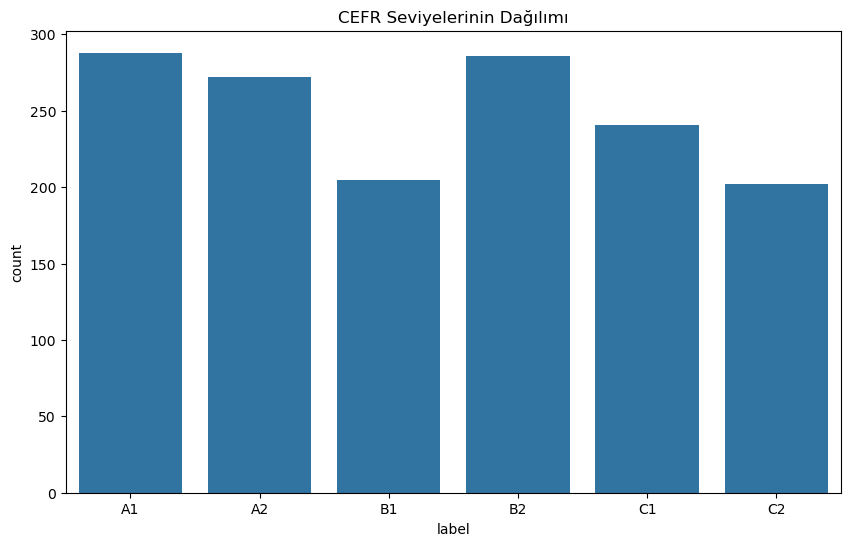

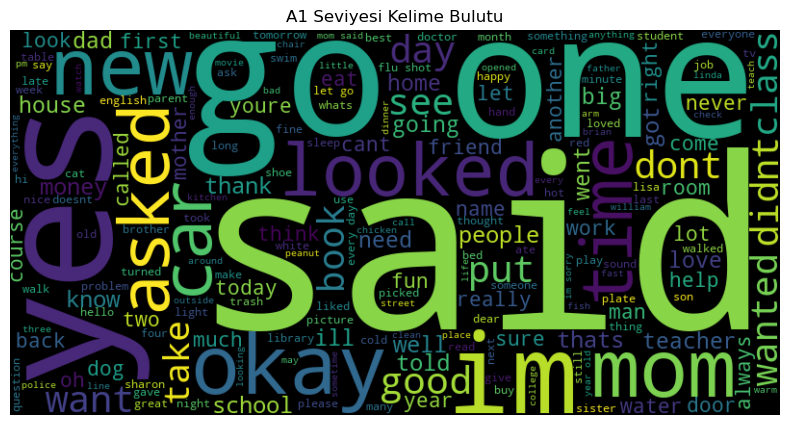

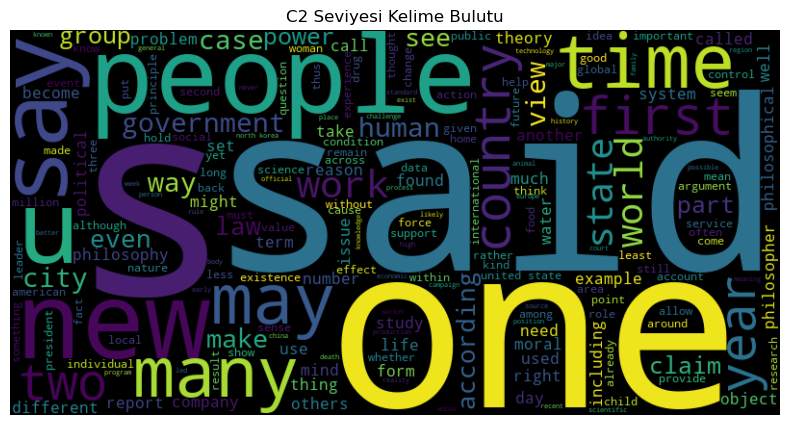

In [3]:
# CEFR seviyelerinin dağılımı
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='label', order=['A1','A2','B1','B2','C1','C2'])
plt.title('CEFR Seviyelerinin Dağılımı')
plt.show()

# Kelime bulutu oluşturma (örnek)
from wordcloud import WordCloud

def generate_wordcloud(level):
    text = ' '.join(df[df['label']==level]['processed_text'])
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{level} Seviyesi Kelime Bulutu')
    plt.axis('off')
    plt.show()

generate_wordcloud('A1')
generate_wordcloud('C2')

In [4]:
# Özellik çıkarımı
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df['processed_text'])

# Etiket kodlama
le = LabelEncoder()
y = le.fit_transform(df['label'])

# Veriyi bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Farklı Modeller Deneme
models = {
    'SVM': SVC(kernel='linear', probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Naive Bayes': MultinomialNB(),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
}

results = {}

for name, model in models.items():
    print(f"\n{name} modeli eğitiliyor...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
    results[name] = report
    print(classification_report(y_test, y_pred, target_names=le.classes_))


SVM modeli eğitiliyor...
              precision    recall  f1-score   support

          A1       0.69      0.79      0.74        67
          A2       0.58      0.56      0.57        52
          B1       0.53      0.28      0.36        36
          B2       0.47      0.67      0.55        54
          C1       0.52      0.51      0.51        51
          C2       0.85      0.56      0.68        39

    accuracy                           0.59       299
   macro avg       0.60      0.56      0.57       299
weighted avg       0.60      0.59      0.58       299


Random Forest modeli eğitiliyor...
              precision    recall  f1-score   support

          A1       0.65      0.96      0.77        67
          A2       0.61      0.42      0.50        52
          B1       0.56      0.14      0.22        36
          B2       0.40      0.65      0.50        54
          C1       0.44      0.37      0.40        51
          C2       0.68      0.44      0.53        39

    accuracy   

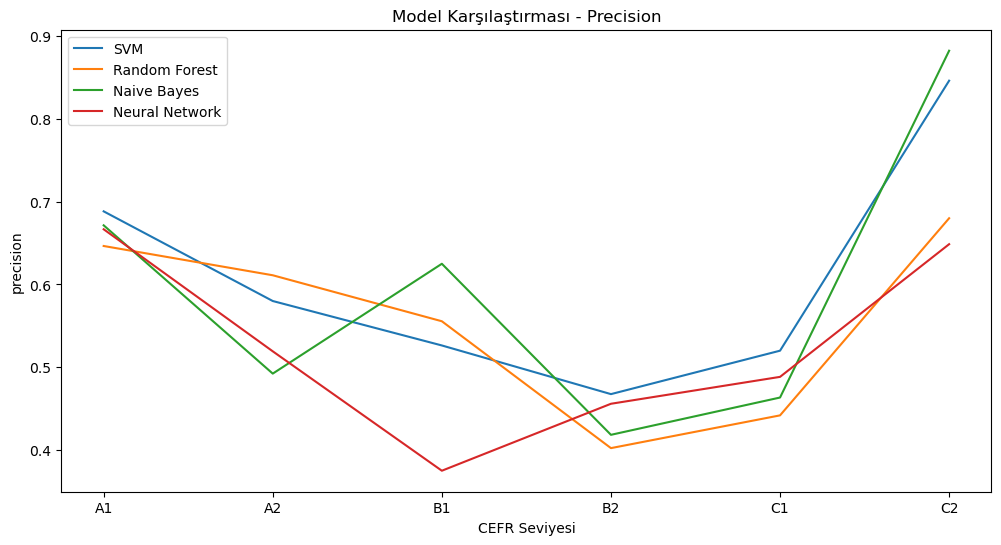

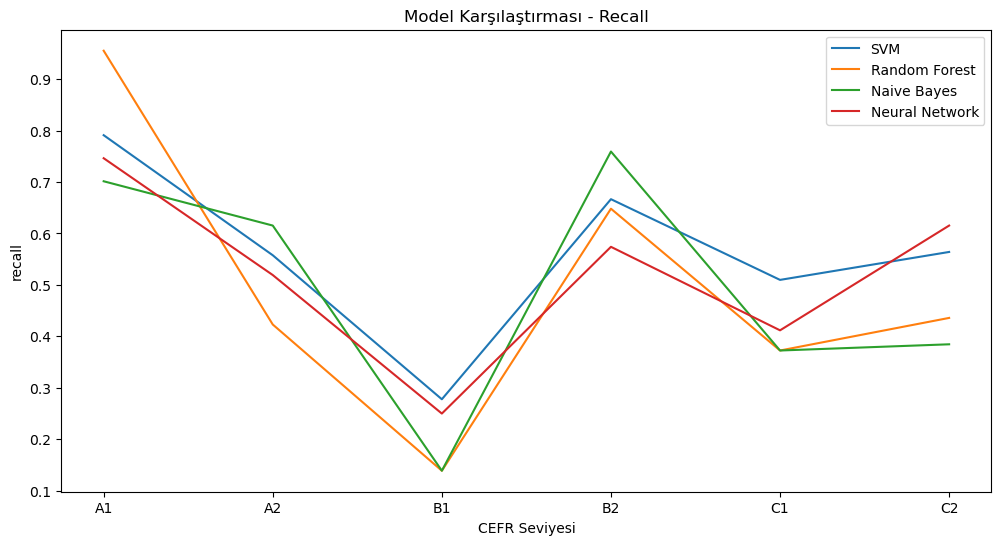

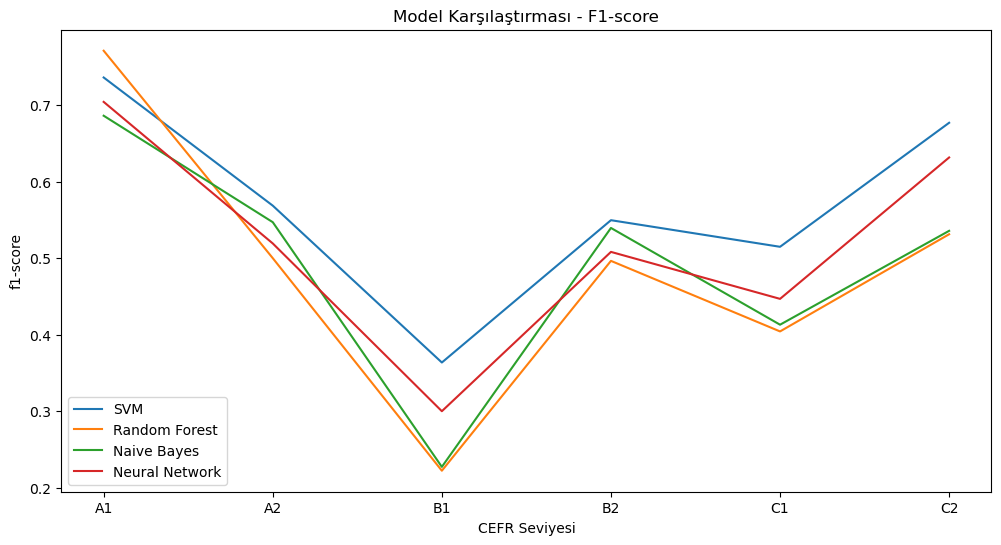


En iyi performans gösteren model: SVM


In [5]:
# Model performanslarını karşılaştırma
metrics = ['precision', 'recall', 'f1-score']
for metric in metrics:
    plt.figure(figsize=(12,6))
    for model in results:
        scores = []
        for level in le.classes_:
            scores.append(results[model][level][metric])
        plt.plot(le.classes_, scores, label=model)
    plt.title(f'Model Karşılaştırması - {metric.capitalize()}')
    plt.xlabel('CEFR Seviyesi')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

# En iyi modeli seçme
best_model_name = max(results, key=lambda x: results[x]['weighted avg']['f1-score'])
best_model = models[best_model_name]
print(f"\nEn iyi performans gösteren model: {best_model_name}")

In [6]:
import joblib

# En iyi modeli ve gerekli nesneleri kaydet
joblib.dump(best_model, 'my_cefr_model.pkl')
joblib.dump(tfidf, 'my_tfidf_vectorizer.pkl')
joblib.dump(le, 'my_label_encoder.pkl')

# Model yükleme fonksiyonu
def load_my_model():
    model = joblib.load('my_cefr_model.pkl')
    tfidf = joblib.load('my_tfidf_vectorizer.pkl')
    le = joblib.load('my_label_encoder.pkl')
    return model, tfidf, le

# Tahmin fonksiyonu
def predict_with_my_model(sentence, model, tfidf, le):
    processed = preprocess_text(sentence)
    vector = tfidf.transform([processed])
    prediction = model.predict(vector)
    proba = model.predict_proba(vector)[0]
    return le.inverse_transform(prediction)[0], {level: prob for level, prob in zip(le.classes_, proba)}

# Kullanım örneği
model, tfidf, le = load_my_model()
sentence = "This is a complex sentence that might be at an advanced level."
level, probabilities = predict_with_my_model(sentence, model, tfidf, le)
print(f"Tahmin edilen seviye: {level}")
print("Olasılıklar:", probabilities)

Tahmin edilen seviye: C2
Olasılıklar: {'A1': 0.15306846704621851, 'A2': 0.056329660458704876, 'B1': 0.11470599080209376, 'B2': 0.11849324794868964, 'C1': 0.16978698620079002, 'C2': 0.38761564754350314}


In [1]:
import joblib

# Model yükleme fonksiyonu
def load_my_model():
    model = joblib.load('my_cefr_model.pkl')
    tfidf = joblib.load('my_tfidf_vectorizer.pkl')
    le = joblib.load('my_label_encoder.pkl')
    return model, tfidf, le

# Tahmin fonksiyonu
def predict_with_my_model(sentence, model, tfidf, le):
    processed = preprocess_text(sentence)
    vector = tfidf.transform([processed])
    prediction = model.predict(vector)
    proba = model.predict_proba(vector)[0]
    return le.inverse_transform(prediction)[0], {level: prob for level, prob in zip(le.classes_, proba)}

# Metin ön işleme fonksiyonu (örnek, sizin gerçek fonksiyonunuzu kullanmalısınız)
def preprocess_text(text):
    # Burada metin ön işleme adımlarınızı ekleyin
    # Örnek: küçük harfe çevirme, noktalama işaretlerini kaldırma vb.
    return text.lower()

# Ana program
if __name__ == "__main__":
    # Modeli yükle
    model, tfidf, le = load_my_model()
    
    # Kullanıcıdan metin girişi al
    print("CEFR seviye tahmin sistemine hoş geldiniz!")
    print("Çıkmak için 'q' tuşuna basın.")
    
    while True:
        sentence = input("\nLütfen seviyesini tahmin etmek istediğiniz İngilizce cümleyi girin: ")
        
        if sentence.lower() == 'q':
            print("Program sonlandırılıyor...")
            break
            
        if not sentence.strip():
            print("Lütfen geçerli bir cümle girin!")
            continue
            
        try:
            # Tahmin yap
            level, probabilities = predict_with_my_model(sentence, model, tfidf, le)
            
            # Sonuçları göster
            print(f"\nTahmin edilen seviye: {level}")
            print("Olasılıklar:")
            for lvl, prob in probabilities.items():
                print(f"{lvl}: {prob:.2%}")
                
        except Exception as e:
            print(f"Bir hata oluştu: {str(e)}")

CEFR seviye tahmin sistemine hoş geldiniz!
Çıkmak için 'q' tuşuna basın.

Tahmin edilen seviye: A1
Olasılıklar:
A1: 66.09%
A2: 22.09%
B1: 6.61%
B2: 3.09%
C1: 1.26%
C2: 0.86%


KeyboardInterrupt: Interrupted by user